<a href="https://colab.research.google.com/github/pachterlab/COVID-19-testing-database/blob/master/notebooks/basic_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook reproduces the results and figures in "Markedly heterogeneous COVID-19 testing plans among US universities" by A. Sina Booeshaghi, Fayth Tan, Benjy Renton, Zackary Berger and Lior Pachter

In [1]:
!date

Sat Aug  8 12:32:30 UTC 2020


## Setup

In [2]:
!git clone https://github.com/pachterlab/COVID-19-testing-database.git

Cloning into 'COVID-19-testing-database'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 82 (delta 21), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [3]:
!wget --output-file="logs.csv" "https://docs.google.com/spreadsheets/d/10I8bVkLzvrmXJsb5N-8JSFpWw5vBwDKYzyOVAI4viKo/export?format=csv&gid=1514440859" -O "sheet.csv"

In [4]:
!awk 'NR>4' sheet.csv > data.csv

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats

def nd(arr):
  return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [6]:
df = pd.read_csv("data.csv")
df.index = df.institution.values
top_states = df.groupby("state").count().institution.sort_values(ascending=False).head(5).index.values


In [7]:
top_states

array(['CA', 'NY', 'PA', 'TX', 'MA'], dtype=object)

## Basic stats

In [8]:
df.testing.value_counts()/df.testing.value_counts().sum()*100

TRUE       53.952569
FALSE      37.351779
Unknown     8.695652
Name: testing, dtype: float64

In [9]:
df.test_initial.value_counts()/df.test_initial.value_counts().sum()*100

FALSE      62.252964
TRUE       26.877470
Unknown    10.869565
Name: test_initial, dtype: float64

In [10]:
df.test_recurring.value_counts()/df.test_recurring.value_counts().sum()*100

FALSE      65.544554
TRUE       19.801980
Unknown    14.653465
Name: test_recurring, dtype: float64

In [11]:
df.test_vendor.value_counts().sort_values(ascending=False)

Broad Institute                                                                                      21
Student Health                                                                                        5
Quest                                                                                                 4
Vault Health                                                                                          3
In house lab                                                                                          2
                                                                                                     ..
Baylor Genetics, Houston Medical Hospital                                                             1
Charleston Area Medical Center                                                                        1
Union County                                                                                          1
ASU Health, Alabama Department of Public Health (ADPH) and the M

In [12]:
df.query("test_vendor=='Broad Institute'").state.value_counts()

MA    11
NY     3
ME     2
CT     1
IN     1
VT     1
OH     1
RI     1
Name: state, dtype: int64

In [13]:
v = df.groupby(["state", "testing"]).size().unstack(fill_value=0).sort_values(by="TRUE")
v

testing,FALSE,TRUE,Unknown
state,,,
AK,1,0,0
SD,4,0,0
MT,2,0,0
HI,0,0,1
MS,1,0,0
WY,1,1,0
LA,8,1,0
KY,1,1,0
WA,6,2,0


In [14]:
v = df.groupby(["state", "testing"]).size().unstack(fill_value=0).sort_values(by="TRUE")
(v/v.sum(axis=1)[:,None]*100).sort_values(by="TRUE", ascending=False)

testing,FALSE,TRUE,Unknown
state,,,
NH,0.000000,100.000000,0.000000
NV,0.000000,100.000000,0.000000
RI,0.000000,100.000000,0.000000
MN,0.000000,100.000000,0.000000
MA,7.407407,85.185185,7.407407
ME,0.000000,83.333333,16.666667
CT,16.666667,83.333333,0.000000
VA,18.181818,81.818182,0.000000
KS,20.000000,80.000000,0.000000


In [15]:
# confusion matrix, testing initial vs testing recurring
v = df.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
print(v)

test_recurring  FALSE  TRUE  Unknown
test_initial                        
FALSE             298    10        7
TRUE               30    86       19
Unknown             3     3       48


In [16]:
# Testing based on school type
v = df.groupby(['school_type', 'test_initial']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
print(v)
print("\n")
print(v/v.values.sum(axis=1)[:,None]*100)

test_initial  FALSE  TRUE  Unknown
school_type                       
Public          176    37       24
Private         139    99       31


test_initial      FALSE       TRUE    Unknown
school_type                                  
Public        74.261603  15.611814  10.126582
Private       51.672862  36.802974  11.524164


In [17]:
# Testing based on school type
v = df.groupby(['school_type', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
print(v)
print("\n")
print(v/v.values.sum(axis=1)[:,None]*100)

test_recurring  FALSE  TRUE  Unknown
school_type                         
Public            178    27       31
Private           153    73       43


test_recurring      FALSE       TRUE    Unknown
school_type                                    
Public          75.423729  11.440678  13.135593
Private         56.877323  27.137546  15.985130


In [18]:
v = df.groupby(['rtc_model', 'testing']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)

print(v)
print("\n")
print(v/v.values.sum(axis=1)[:,None]*100)

testing                                             FALSE  TRUE  Unknown
rtc_model                                                               
Planning for in-person                                123   131       20
Proposing a hybrid model                               43   123       17
Planning for online                                    21    13        6
Considering a range of scenarios                        1     2        1
Planning for fully and partially online                 1     0        0
All classes online, but many students will live...      0     1        0
Proposing a hybrid model (all students on campus)       0     1        0


testing                                                  FALSE  ...    Unknown
rtc_model                                                       ...           
Planning for in-person                               44.890511  ...   7.299270
Proposing a hybrid model                             23.497268  ...   9.289617
Planning for online      

## Top 5 states by number of universities

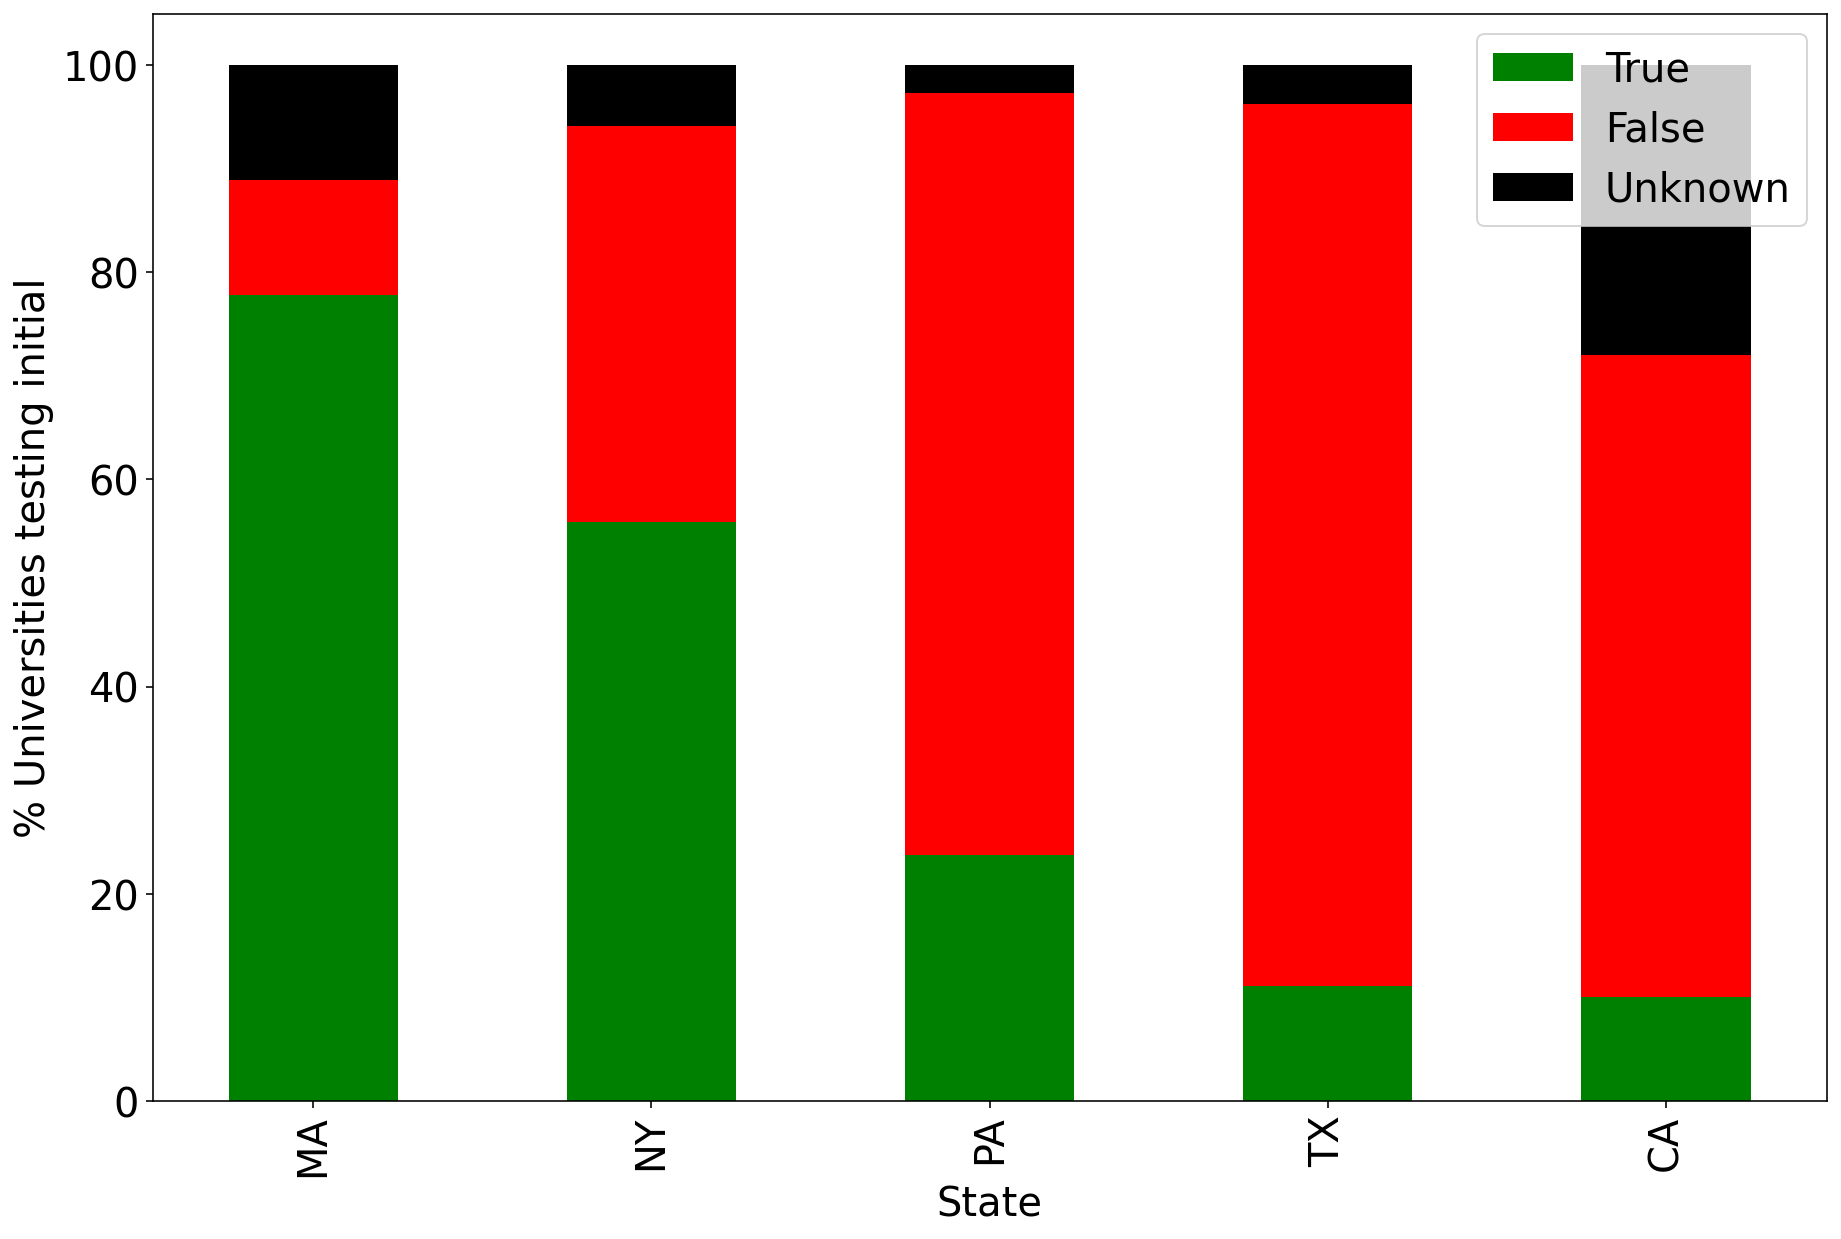

In [19]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values
width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing initial"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

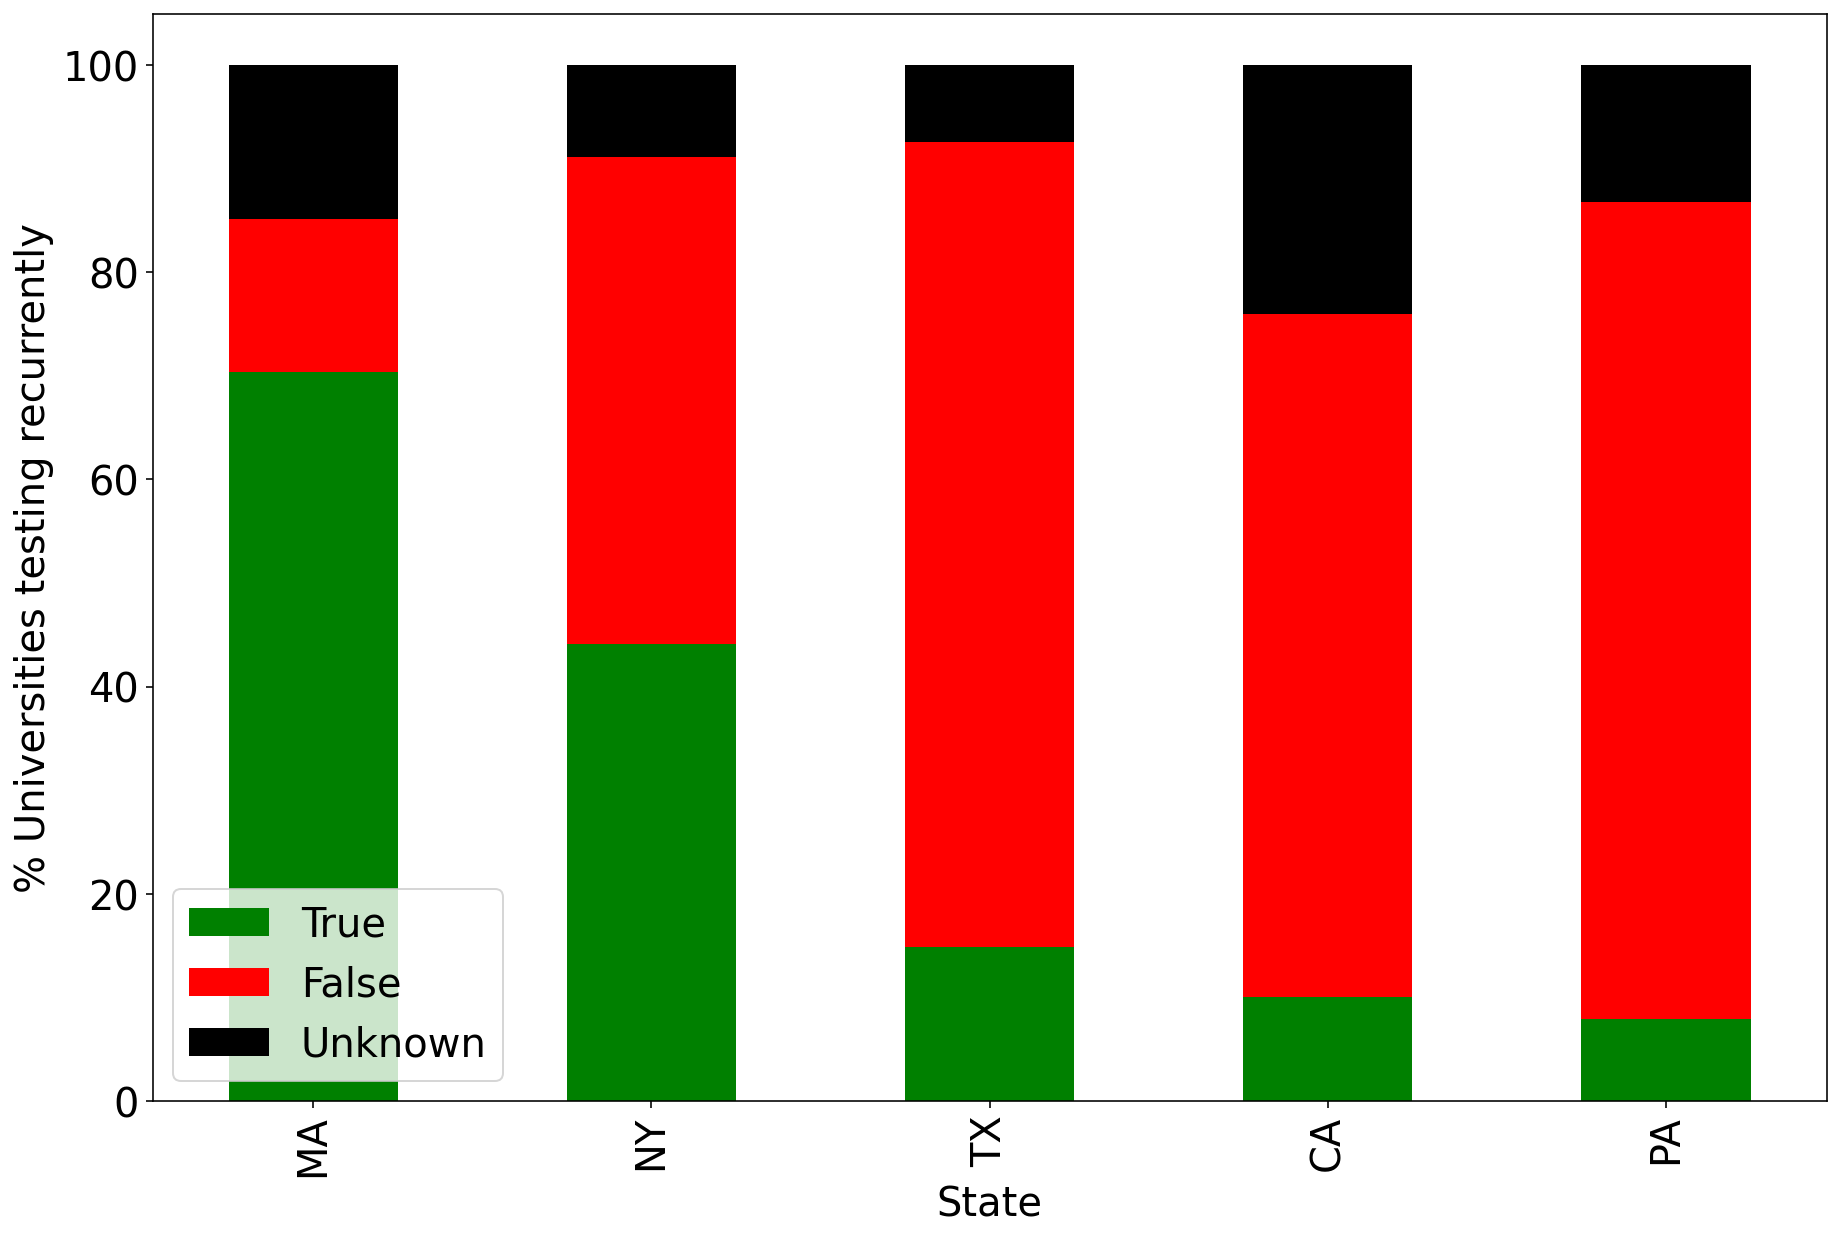

In [20]:
v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
vp = v/v.values.sum(axis=1)[:,None]*100

fig, ax = plt.subplots(figsize=(15,10))

vp  = vp.loc[top_states].sort_values(by="TRUE", ascending=False)
ind = np.arange(vp.shape[0])    # the x locations for the groups
labels = vp.index.values


x = vp.TRUE.values
y = vp.FALSE.values
z = vp.Unknown.values

width = 0.5     # the width of the bars: can also be len(x) sequence

ax.bar(ind, x, width,label="True", color="green")
ax.bar(ind, y, width, bottom=x, label="False", color="red")
ax.bar(ind, z, width, bottom=x+y, label="Unknown", color="black")

kwd = {
    "xticks" : ind,
    "xticklabels": labels,
    "xlabel": "State",
    "ylabel": "% Universities testing recurrently"
}
ax.set(**kwd)
ax.set_xticklabels(labels, rotation=90)
ax.legend()


fig.show()

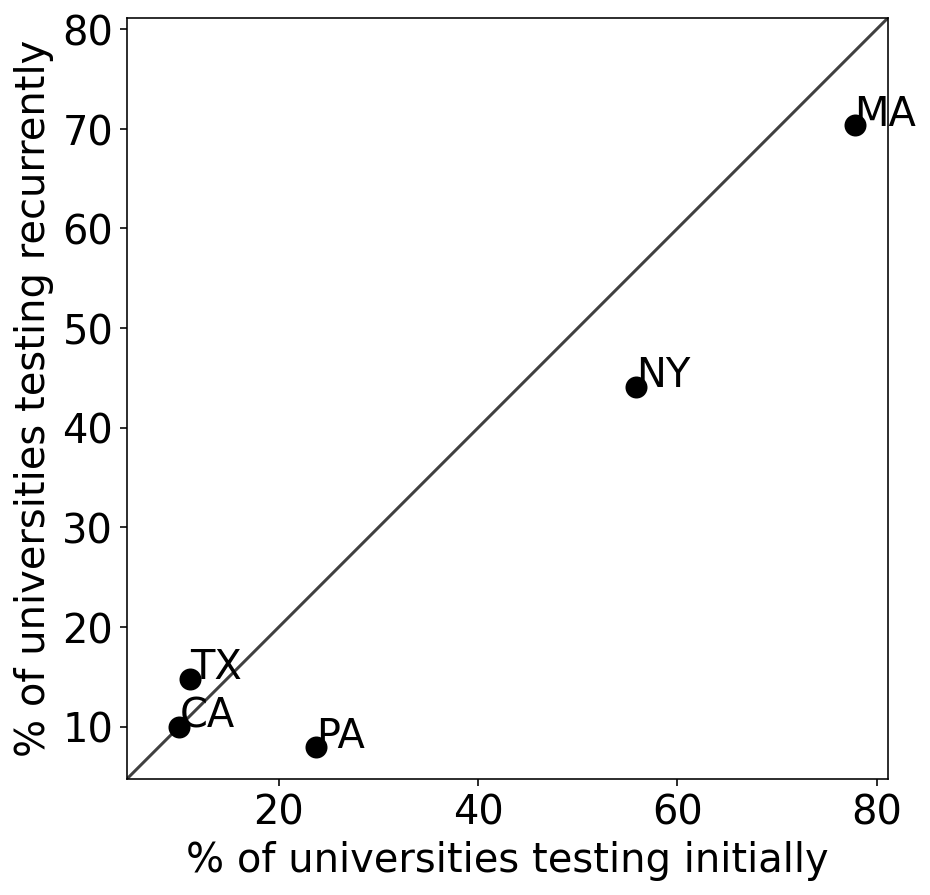

In [21]:
v = df.groupby(['state', 'test_initial']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
initial = v/v.values.sum(axis=1)[:,None]*100

v = df.groupby(['state', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="TRUE", ascending=False)
recurrent = v/v.values.sum(axis=1)[:,None]*100

initial = initial.loc[top_states]
recurrent = recurrent.loc[top_states]

fig, ax = plt.subplots(figsize=(7,7))

x = initial.TRUE.values
y = recurrent.TRUE.values

ax.scatter(x, y, s=100, color="k")
yex(ax)
for (xx, yy, txt) in zip(x, y, top_states):
  ax.annotate(txt, (xx, yy))

kwd = {
    "xlabel": "% of universities testing initially",
    "ylabel": "% of universities testing recurrently"
}
ax.set(**kwd)

fig.show()

## Positivity rate per state

In [22]:
!git clone https://github.com/CSSEGISandData/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 44781, done.
remote: Total 44781 (delta 0), reused 0 (delta 0), pack-reused 44781
Receiving objects: 100% (44781/44781), 342.64 MiB | 31.01 MiB/s, done.
Resolving deltas: 100% (27799/27799), done.
Checking out files: 100% (546/546), done.


In [23]:
old = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/07-30-2020.csv")
daily = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/08-06-2020.csv")

In [24]:
s2a = {
    "Alabama" : "AL",
"Alaska" : "AK",
"Arizona" : "AZ",
"Arkansas" : "AR",
"California" : "CA",
"Colorado" : "CO",
"Connecticut" : "CT",
"Delaware" : "DE",
"Florida" : "FL",
"Georgia" : "GA",
"Hawaii" : "HI",
"Idaho" : "ID",
"Illinois" : "IL",
"Indiana" : "IN",
"Iowa" : "IA",
"Kansas" : "KS",
"Kentucky" : "KY",
"Louisiana" : "LA",
"Maine" : "ME",
"Maryland" : "MD",
"Massachusetts" : "MA",
"Michigan" : "MI",
"Minnesota" : "MN",
"Mississippi" : "MS",
"Missouri" : "MO",
"Montana" : "MT",
"Nebraska" : "NE",
"Nevada" : "NV",
"New Hampshire" : "NH",
"New Jersey" : "NJ",
"New Mexico" : "NM",
"New York" : "NY",
"North Carolina" : "NC",
"North Dakota" : "ND",
"Ohio" : "OH",
"Oklahoma" : "OK",
"Oregon" : "OR",
"Pennsylvania" : "PA",
"Rhode Island" : "RI",
"South Carolina" : "SC",
"South Dakota" : "SD",
"Tennessee" : "TN",
"Texas" : "TX",
"Utah" : "UT",
"Vermont" : "VT",
"Virginia" : "VA",
"Washington" : "WA",
"West Virginia" : "WV",
"Wisconsin" : "WI",
"Wyoming" : "WY"
}

In [25]:
daily.index = daily.Province_State.apply(lambda x: s2a.get(x, x))
old.index = old.Province_State.apply(lambda x: s2a.get(x, x))

In [26]:
pos = (daily.loc[top_states]["Confirmed"]-old.loc[top_states]["Confirmed"])/(daily.loc[top_states]["People_Tested"]-old.loc[top_states]["People_Tested"])

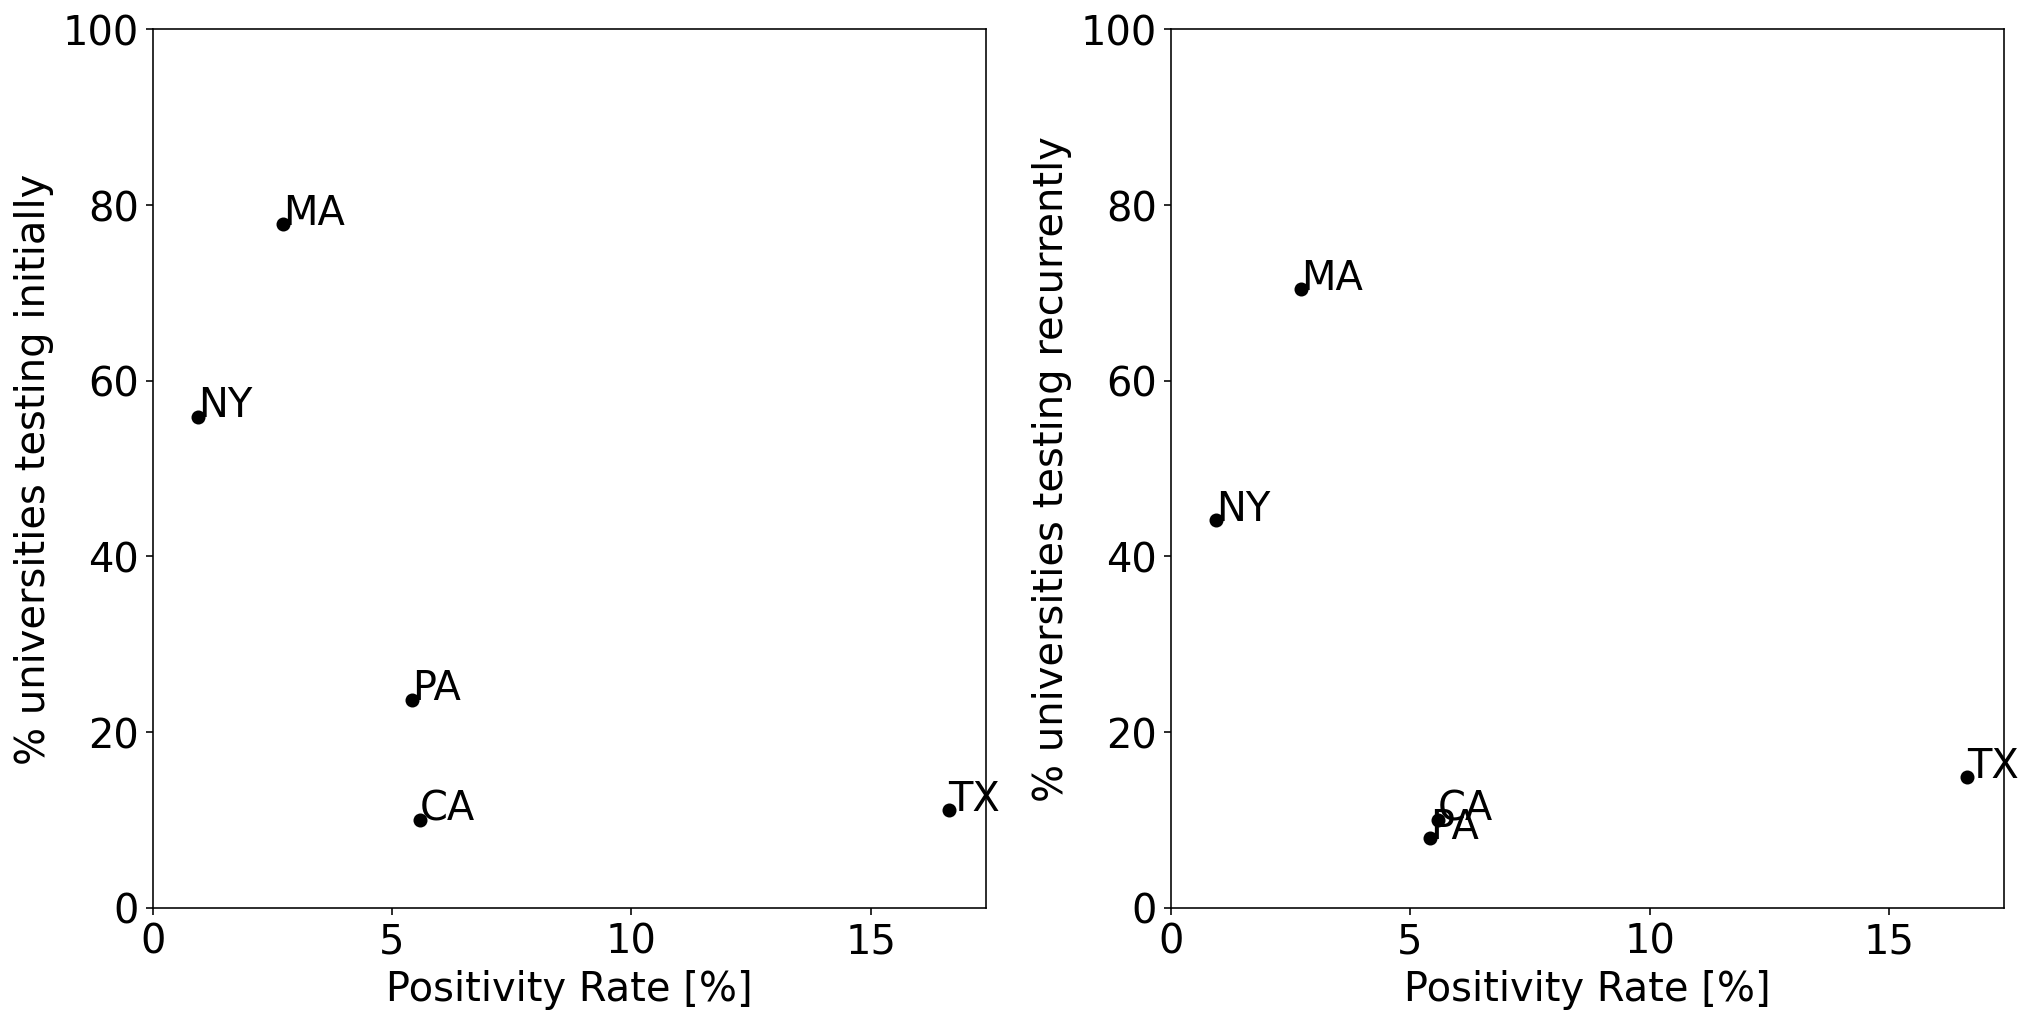

In [27]:
#Figure 1a
fig, ax = plt.subplots(figsize=(14,7), ncols=2, constrained_layout=True)

x = pos*100
y = initial.loc[top_states].TRUE.values

ax[0].scatter(x, y, color="k")

for (xx, yy, txt) in zip(x, y, top_states):
  ax[0].annotate(txt, (xx, yy))

kwd = {
    "xlabel": "Positivity Rate [%]",
    "ylabel": "% universities testing initially",
    "ylim": (0, 100),
    "xlim": (0)
}

ax[0].set(**kwd)

x = pos*100
y = recurrent.loc[top_states].TRUE.values

ax[1].scatter(x, y, color="k")

for (xx, yy, txt) in zip(x, y, top_states):
  ax[1].annotate(txt, (xx, yy))

kwd = {
    "xlabel": "Positivity Rate [%]",
    "ylabel": "% universities testing recurrently",
    "ylim": (0, 100),
    "xlim": (0)
}

ax[1].set(**kwd)

fig.savefig("./top_states.png",bbox_inches='tight', dpi=300)

fig.show()

## Frequency of recurring testing

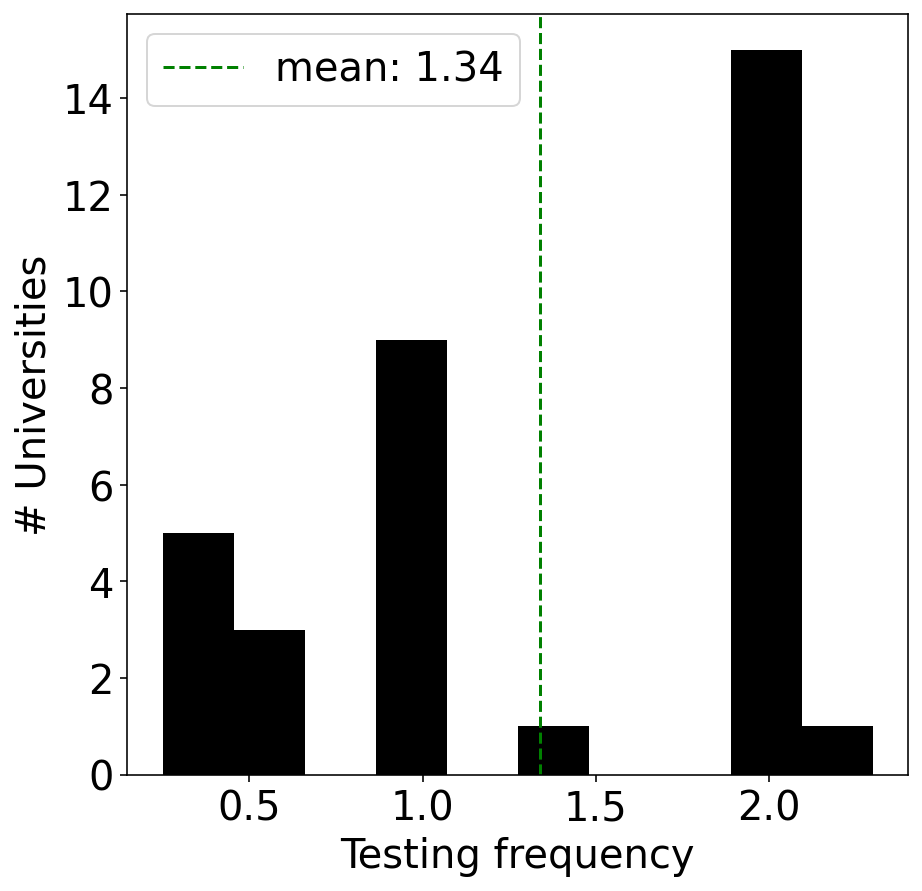

In [28]:
# Figure 1b
fig, ax = plt.subplots(figsize=(7,7))
x = df[df.test_freq.notna()].query("test_freq>0").test_freq.values

mean = x.mean()
ax.hist(x, color="k")
ax.axvline(mean, label=f"mean: {mean:,.2f}", color="green", linestyle="--")
kwd = {
    "xlabel": "Testing frequency",
    "ylabel": "# Universities"
}
ax.set(**kwd)
ax.legend()

fig.savefig("./frequency.png",bbox_inches='tight', dpi=300)
fig.show()

## US News top universities

In [29]:
usnr = pd.read_excel("http://andyreiter.com/wp-content/uploads/2019/09/US-News-Rankings-Universities-Through-2020.xlsx", header=1)

In [30]:
np.setdiff1d(usnr["University Name"], df.institution.values)

array(['College of William and Mary', 'Georgia Institute of Technology',
       'Pennsylvania State University-University Park',
       'Rutgers University-New Brunswick',
       'Texas A&M University-College Station',
       'University of California-Berkeley',
       'University of California-Davis',
       'University of California-Irvine',
       'University of California-Los Angeles',
       'University of California-San Diego',
       'University of California-Santa Barbara', 'University of Georgia',
       'University of Illinois-Urbana-Champaign',
       'University of Michigan-Ann Arbor',
       'University of North Carolina-Chapel Hill',
       'University of Texas-Austin', 'University of Wisconsin-Madison'],
      dtype=object)

In [31]:
top_map = {
  'College of William and Mary':"College of William & Mary", 
  'Georgia Institute of Technology': "University System of Georgia — Georgia Institute of Technology",
  'Pennsylvania State University-University Park': "Pennsylvania State University",
  'Rutgers University-New Brunswick': "Rutgers University",
  'Texas A&M University-College Station': "Texas A&M University system — College Station",
  'University of California-Berkeley': "University of California at Berkeley",
  'University of California-Davis':"University of California at Davis",
  'University of California-Irvine':"University of California at Irvine",
  'University of California-Los Angeles': "University of California at Los Angeles",
  'University of California-San Diego': "University of California at San Diego",
  'University of California-Santa Barbara': "University of California at Santa Barbara", 
  'University of Georgia': "University System of Georgia — University of Georgia",
  'University of Illinois-Urbana-Champaign': "University of Illinois at Urbana-Champaign",
  'University of Michigan-Ann Arbor': "University of Michigan at Ann Arbor",
  'University of North Carolina-Chapel Hill': "University of North Carolina at Chapel Hill",
  'University of Texas-Austin':"University of Texas at Austin", 
  'University of Wisconsin-Madison': "University of Wisconsin at Madison"
}

In [32]:
usnr["University Name"] = usnr["University Name"].apply(lambda x: top_map.get(x, x))

In [33]:
usnr = usnr[usnr[2020].notna()].sort_values(2020).head(50)

In [34]:
top_uni = df[df.institution.isin(usnr["University Name"].values)]

In [35]:
top_uni.groupby(["rtc_model", "testing"]).size().unstack(fill_value=0)

testing,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,0,8,0
Planning for online,0,5,0
Proposing a hybrid model,1,33,1


In [36]:
top_uni.query("testing=='FALSE'")

,institution,school_type,state,testing_info_link,rtc_model,last_updated,testing,testing_type,test_initial,test_recurring,test_freq,test_vendor,test_pool,endowment,enrollment,endowment_per_fte_enrollment,comments
Case Western Reserve University,Case Western Reserve University,Private,OH,https://case.edu/studentlife/healthcounseling/...,Proposing a hybrid model,7/28/2020,FALSE,No voluntary testing,FALSE,FALSE,0.0,NaN,NaN,1.886761e+09,11890.0,175089.0,Re-entry testing for students just announced (...


In [37]:
top_uni.query("testing=='Unknown'")

,institution,school_type,state,testing_info_link,rtc_model,last_updated,testing,testing_type,test_initial,test_recurring,test_freq,test_vendor,test_pool,endowment,enrollment,endowment_per_fte_enrollment,comments
Washington University in St. Louis,Washington University in St. Louis,Private,MO,https://covid19.wustl.edu/health-safety/,Proposing a hybrid model,7/30/2020,Unknown,Unknown,Unknown,Unknown,0.0,NaN,NaN,NaN,NaN,NaN,One of the most obtuse websites. But no mentio...


In [38]:
top_uni.groupby(["rtc_model", "test_initial"]).size().unstack(fill_value=0)

test_initial,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0,1,0
Considering a range of scenarios,0,1,0
Planning for in-person,2,5,1
Planning for online,3,2,0
Proposing a hybrid model,7,25,3


In [39]:
v = top_uni.groupby(["rtc_model", "test_recurring"]).size().unstack(fill_value=0)
print(v)
print("\n")
v/v.sum(axis=1)[:,None]*100

test_recurring                                      FALSE  TRUE  Unknown
rtc_model                                                               
All classes online, but many students will live...      0     0        1
Considering a range of scenarios                        0     1        0
Planning for in-person                                  4     3        1
Planning for online                                     3     2        0
Proposing a hybrid model                               11    20        4




test_recurring,FALSE,TRUE,Unknown
rtc_model,,,
"All classes online, but many students will live on campus",0.000000,0.000000,100.000000
Considering a range of scenarios,0.000000,100.000000,0.000000
Planning for in-person,50.000000,37.500000,12.500000
Planning for online,60.000000,40.000000,0.000000
Proposing a hybrid model,31.428571,57.142857,11.428571


In [40]:
v = top_uni.groupby(["school_type", "testing"]).size().unstack(fill_value=0)
print(v)
v/v.sum(axis=1)[:,None]*100

testing      FALSE  TRUE  Unknown
school_type                      
Private          1    33        1
Public           0    15        0


testing,FALSE,TRUE,Unknown
school_type,,,
Private,2.857143,94.285714,2.857143
Public,0.000000,100.000000,0.000000


In [41]:
v.sum(axis=0)["TRUE"]/v.sum(axis=0).sum()*100

96.0

In [42]:
v = top_uni.groupby(["school_type", "test_initial"]).size().unstack(fill_value=0)
print(v)
v/v.sum(axis=1)[:,None]*100

test_initial  FALSE  TRUE  Unknown
school_type                       
Private           3    29        3
Public            9     5        1


test_initial,FALSE,TRUE,Unknown
school_type,,,
Private,8.571429,82.857143,8.571429
Public,60.000000,33.333333,6.666667


In [43]:
v = top_uni.groupby(["school_type", "test_recurring"]).size().unstack(fill_value=0)
print(v)
v/v.sum(axis=1)[:,None]

test_recurring  FALSE  TRUE  Unknown
school_type                         
Private             8    22        5
Public             10     4        1


test_recurring,FALSE,TRUE,Unknown
school_type,,,
Private,0.228571,0.628571,0.142857
Public,0.666667,0.266667,0.066667


### Complement of top universities

In [44]:
# look at the complement of top universities 
v = df[~df.institution.isin(top_uni.institution.values)].groupby(["school_type", "testing"]).size().unstack(fill_value=0)
print(v)
v/v.sum(axis=1)[:,None]

testing      FALSE  TRUE  Unknown
school_type                      
Private         86   119       29
Public         102   106       14


testing,FALSE,TRUE,Unknown
school_type,,,
Private,0.367521,0.508547,0.123932
Public,0.459459,0.477477,0.063063


In [45]:
v.sum(axis=0)["TRUE"]/v.sum(axis=0).sum()*100

49.34210526315789

In [46]:
# look at the complement of top universities 
v = df[~df.institution.isin(top_uni.institution.values)].groupby(["school_type", "test_initial"]).size().unstack(fill_value=0)
print(v)
v/v.sum(axis=1)[:,None]

test_initial  FALSE  TRUE  Unknown
school_type                       
Private         136    70       28
Public          167    32       23


test_initial,FALSE,TRUE,Unknown
school_type,,,
Private,0.581197,0.299145,0.119658
Public,0.752252,0.144144,0.103604


In [47]:
v = df[~df.institution.isin(top_uni.institution.values)].groupby(["school_type", "test_recurring"]).size().unstack(fill_value=0)
print(v)
v/v.sum(axis=1)[:,None]

test_recurring  FALSE  TRUE  Unknown
school_type                         
Private           145    51       38
Public            168    23       30


test_recurring,FALSE,TRUE,Unknown
school_type,,,
Private,0.619658,0.217949,0.162393
Public,0.760181,0.104072,0.135747


In [48]:
v = top_uni.groupby(['test_initial', 'test_recurring']).size().unstack(fill_value=0).sort_values(by="FALSE", ascending=False)
v

test_recurring,FALSE,TRUE,Unknown
test_initial,,,
FALSE,11,1,0
TRUE,6,25,3
Unknown,1,0,3


## Endowment and testing

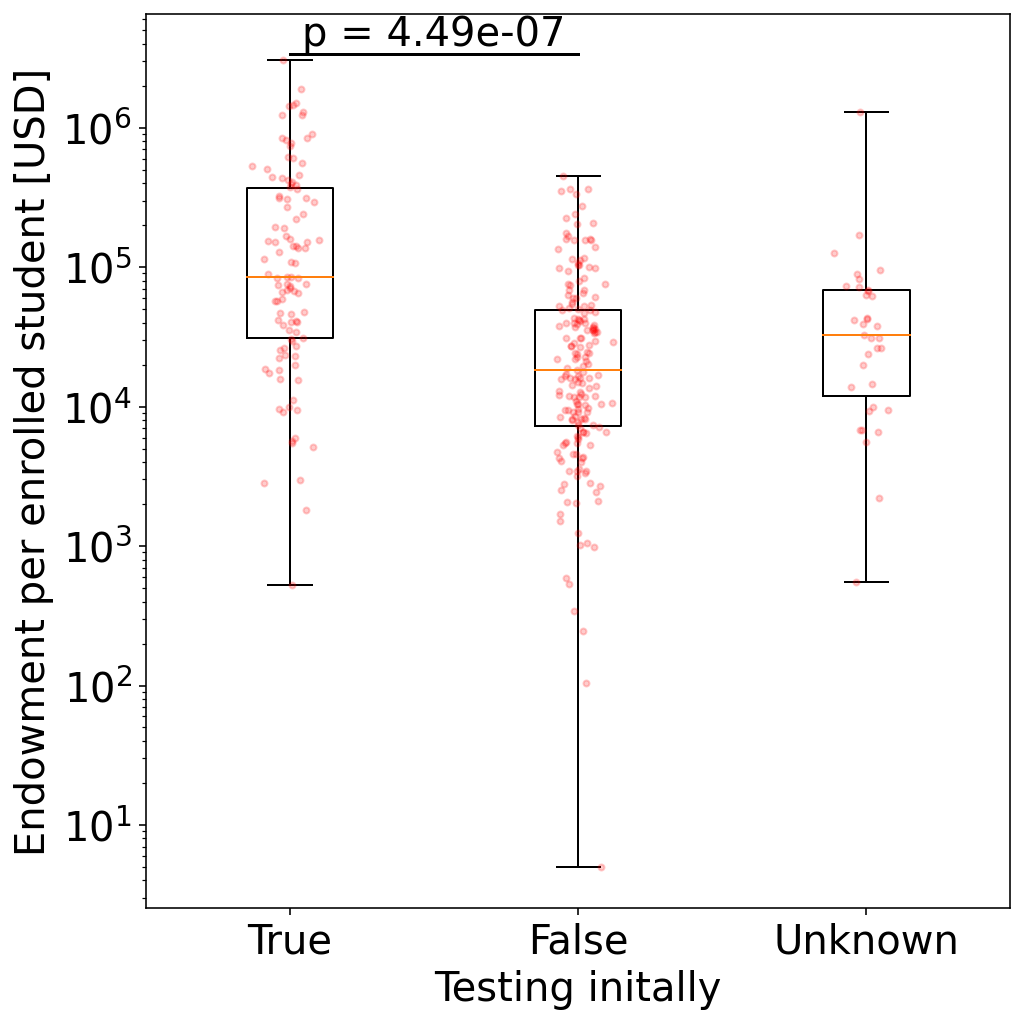

In [49]:
#Figure 1c
v = df[df["endowment_per_fte_enrollment"].notnull()].groupby("test_initial")["endowment_per_fte_enrollment"].apply(list)
f, t, u = v
tval, pval = stats.ttest_ind(t, f, equal_var=False)

fig, ax = plt.subplots(figsize=(7,7), constrained_layout=True)

labels = ["True", "False", "Unknown"]

data = [t, f, u]
ax.boxplot(data, whis=(0, 100))

for i in range(len(data)):
    y = data[i]
    x = np.random.normal(1+i, 0.04, size=len(y))
    ax.plot(x, y, 'r.', alpha=0.2)

# statistical annotation
x1, x2 = 1, 2   
yy, h, col = max(t)*(1+0.1), 0, 'k'
ax.plot([x1, x1, x2, x2], [yy, yy+h, yy+h, yy], lw=1.5, c=col)
ax.text((x1+x2)*.5, yy+h, f"p = {pval:,.2e}", ha='center', va='bottom', color=col)

kwd = {
    "xlabel" : "Testing initally",
    "ylabel": "Endowment per enrolled student [USD]",
    "yscale": "log",
    "xticklabels":labels
}
ax.set(**kwd)

fig.savefig("./endowment.png",bbox_inches='tight', dpi=300)

fig.show()

In [50]:
!date

Sat Aug  8 12:33:15 UTC 2020
